In [1]:
library(data.table)
library(mltools)
library(sparseGraph)
library(spectralGraphTopology)
library(igraph)
library(scales)
set.seed(42)


Attaching package: ‘spectralGraphTopology’


The following object is masked from ‘package:stats’:

    D



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message:
“package ‘scales’ was built under R version 3.6.2”


In [2]:
df <- read.csv("corona-virus.csv")

In [3]:
df <- one_hot(as.data.table(df))

In [4]:
p <- nrow(df)

In [5]:
Y <- t(matrix(as.numeric(unlist(df)), nrow = nrow(df)))
labels <- Y[nrow(Y), 1:p]

In [6]:
Y <- Y[1:(nrow(Y)-1), 1:p]

In [7]:
dim(Y)

[1] 32 98

In [8]:
S <- cor(Y)

In [9]:
graph_mcp <- learn_laplacian_pgd_connected(S = S + diag(1/p, p, p),
                                           alpha = 1.2, sparsity_type = "mcp", gamma = 1.01,
                                           verbose = FALSE, maxiter = 1000)

In [10]:
graph_scad <- learn_laplacian_pgd_connected(S = S + diag(1/p, p, p),
                                           alpha = .65, sparsity_type = "scad", gamma = 2.01,
                                           verbose = FALSE, maxiter = 1000)

In [11]:
graph_admm <- learn_laplacian_gle_admm(S = S + diag(1/p, p, p), verbose = FALSE)

In [12]:
.5 * sum(graph_scad$adjacency > 0)

[1] 345

In [13]:
.5 * sum(graph_mcp$adjacency > 0)

[1] 348

In [14]:
.5 * sum(graph_admm$Adjacency > 0)

[1] 4697

In [15]:
graph_mcp$elapsed_time[length(graph_mcp$elapsed_time)]

elapsed 
  0.704

In [16]:
graph_scad$elapsed_time[length(graph_scad$elapsed_time)]

elapsed 
  1.519

In [17]:
net <- graph_from_adjacency_matrix(graph_mcp$adjacency, mode = "undirected", weighted = TRUE)
la_true <- layout_nicely(net)
colors <- c("#1abc9c", "#ff5252")
clusters <- array(0, length(labels))
for (i in c(1:length(labels))) {
  if (labels[i] == 0) {
    clusters[i] = 1
  } else if (labels[i] == 1) {
    clusters[i] = 2
  }
}
V(net)$cluster <- clusters
E(net)$color <- apply(as.data.frame(get.edgelist(net)), 1,
                     function(x) ifelse(V(net)$cluster[x[1]] == V(net)$cluster[x[2]],
                                        colors[V(net)$cluster[x[1]]], "grey"))
V(net)$color <- colors[clusters]

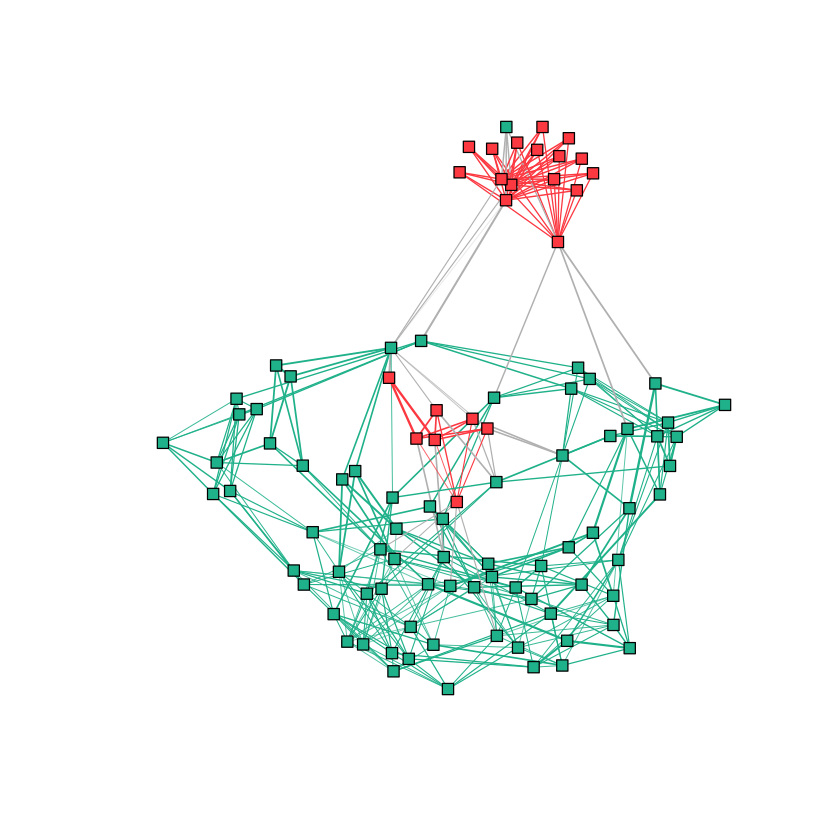

In [18]:
plot(net, layout = la_true,
     vertex.label = NA, vertex.size = 4, vertex.shape = 'square',
     edge.width = E(net)$weight / mean(E(net)$weight))

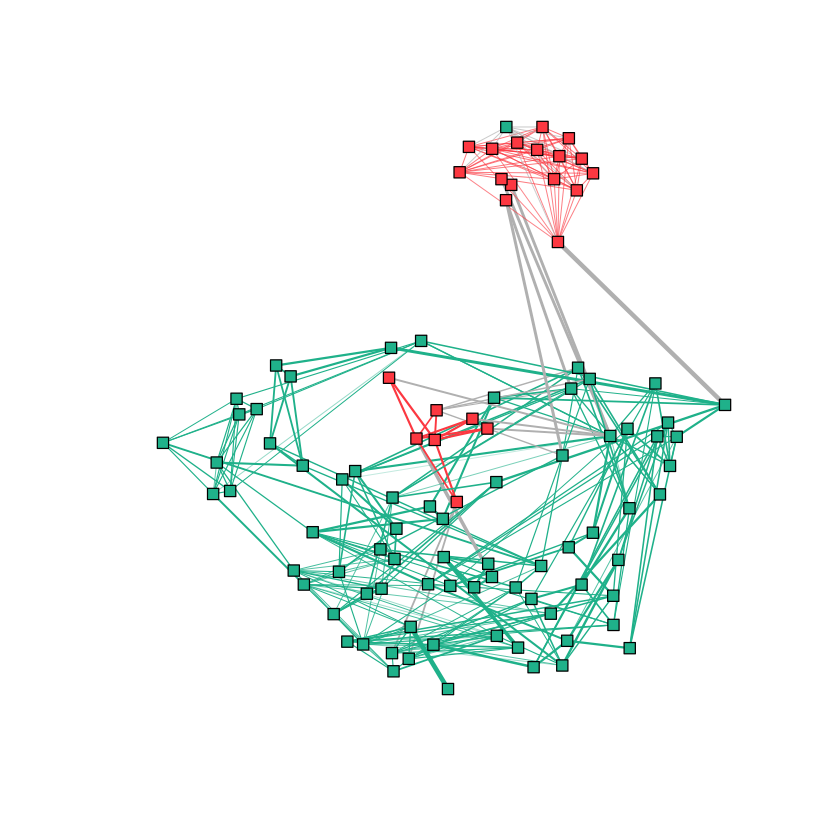

In [19]:
net <- graph_from_adjacency_matrix(graph_scad$adjacency, mode = "undirected", weighted = TRUE)
V(net)$cluster <- clusters
E(net)$color <- apply(as.data.frame(get.edgelist(net)), 1,
                     function(x) ifelse(V(net)$cluster[x[1]] == V(net)$cluster[x[2]],
                                        colors[V(net)$cluster[x[1]]], "grey"))
V(net)$color <- colors[clusters]
plot(net, layout = la_true,
     vertex.label = NA, vertex.size = 4, vertex.shape = 'square',
     edge.width = E(net)$weight / mean(E(net)$weight))

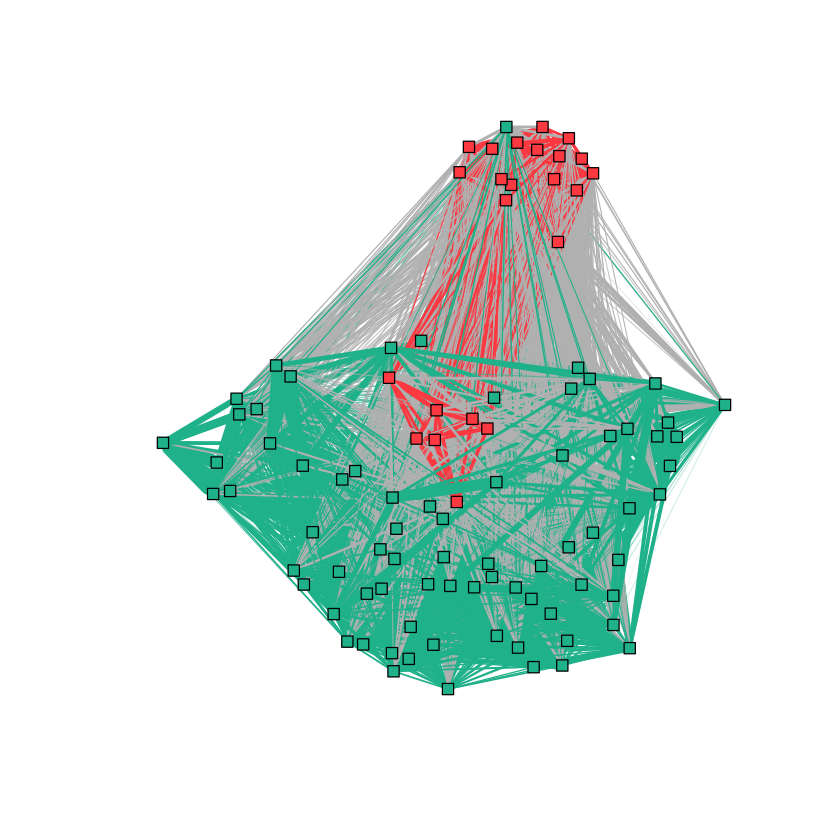

In [20]:
net <- graph_from_adjacency_matrix(graph_admm$Adjacency, mode = "undirected", weighted = TRUE)
V(net)$cluster <- clusters
E(net)$color <- apply(as.data.frame(get.edgelist(net)), 1,
                     function(x) ifelse(V(net)$cluster[x[1]] == V(net)$cluster[x[2]],
                                        colors[V(net)$cluster[x[1]]], "grey"))
V(net)$color <- colors[clusters]
plot(net, layout = la_true,
     vertex.label = NA, vertex.size = 4, vertex.shape = 'square',
     edge.width = E(net)$weight / mean(E(net)$weight))